<a href="https://colab.research.google.com/github/jfhiguita/Tweet_Disasters/blob/master/prediccion_desastres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Take a first look at the data** <br>
The first thing we'll need to do is load in the libraries and dataset we'll be using.


In [39]:
#Install the emoji library
!pip install emoji --upgrade
!pip install geopandas
# load modules we'll going to use
import pandas as pd
import numpy as np
#load module to convert emoji flags to strings
import emoji
# Modules for plotting
import seaborn as sns
from matplotlib import pyplot as plt
# Modules for text proccesing
import re
import string
#Import Nominatim for transform city names
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point , Polygon
import descartes

Requirement already up-to-date: emoji in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [40]:
# read the file
#from google.colab import files
#uploaded = files.upload()

In [41]:
#from google.colab import drive
#drive.mount('/content/drive')

In [42]:
#import io
#df = pd.read_csv(io.BytesIO(uploaded['tweets.csv']))
# Dataset is now stored in a Pandas Dataframe
#df

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# si lo tienes en tu Drive (no en compartido)
!ls '/content/drive/My Drive/Predicción de desastres con tweets'

df_transform.csv  prediccion_desastres.ipynb  tweets.csv  WordCloud.ipynb


In [45]:
# aca nos dirigimos al path,  entonces ya funciona sin problema la siguiente linea
%cd '/content/drive/My Drive/Predicción de desastres con tweets/'

/content/drive/.shortcut-targets-by-id/1OSeTsfR8kLJ8zmxtsBpiHujRO8uPu0J4/Predicción de desastres con tweets


In [46]:
# Load the Dataset in the data folder and show the sample
df = pd.read_csv('tweets.csv')
df

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [47]:
# set index with id
df = df.set_index('id')
df

,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0


In [48]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function
df['text'] = df['text'].apply(lambda x: clean_text(x))

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['text'] = df['text'].apply(lambda x: deEmojify(x))
# I'm going to comment on this line that I think is the one who return an error
#df.convert_dtypes['location'] = df['location'].apply(lambda x: deEmojify(x))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1
1,ablaze,NaN,telangana section has been imposed in bhainsa...,1
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1
3,ablaze,"Morgantown, WV",arsonist sets cars ablaze at dealership,1
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,media should have warned us well in advance th...,0
11366,wrecked,arohaonces,i feel directly attacked i consider moonbin a...,0
11367,wrecked,🇵🇭,i feel directly attacked i consider moonbin a...,0


# Clean the 'kyword' column

In [49]:
#First we're going to check this column
df.keyword.describe()

count            11370
unique             219
top       thunderstorm
freq                93
Name: keyword, dtype: object

As we can see there are 219 unique values in this column, let's see what are those

In [50]:
# get all the unique values in the 'keyword' column
keywords = df['keyword'].unique()

# sort them alphabetically and then take a closer look
keywords.sort()
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'bush%20fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desol

As we can see the only characters that are unusual are "%20" ones, so we can replace them for an empty space.

In [51]:
#Remove the "%20" from the registers in the column 'keyword'
df['keyword'] = df['keyword'].apply(lambda x: x.replace("%20"," "))

#Change the dtype of the column from object to str
df.keyword = df.keyword.astype(str)

# get all the unique values in the 'keyword' column
keywords = df['keyword'].unique()

# sort them alphabetically and then take a closer look
keywords.sort()
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'bush fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desolate', 'desolation', 'destr

As we can see, the unique values still remain 219, but we successfully removed all the '%20' characters from our registers in the 'keyword' column.

# Transform the emoji flag to a string in the 'location' column

In [52]:
#Apply quotation marks to all registers in the "location" column (this will allowed us to treat the emoji flags later with the
# emoji library).
df.location = df.location.astype(str)
df.update(df[['location']].applymap('\'{}\''.format))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,'nan',communal violence in bhainsa telangana stones ...,1
1,ablaze,'nan',telangana section has been imposed in bhainsa...,1
2,ablaze,'New York City',arsonist sets cars ablaze at dealership,1
3,ablaze,"'Morgantown, WV'",arsonist sets cars ablaze at dealership,1
4,ablaze,'nan',lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,'Blue State in a red sea',media should have warned us well in advance th...,0
11366,wrecked,'arohaonces',i feel directly attacked i consider moonbin a...,0
11367,wrecked,'🇵🇭',i feel directly attacked i consider moonbin a...,0


In [53]:
#Transform the emoji flags in the location column 
def emojiflag_to_text(flag):
    '''Convert the emoji flag to a string with their name. the emoji flags are two unicode letters that composes 
    for example 🇲🇽 -> MX, so we know that the lenght of an emoji flag is 2, as we put it in a simple quotation marks, 
    we can assume that an emoji flag has lenght equal to 4'''
    if len(flag) == 4:
      return emoji.demojize(flag)
    else:
      return flag
     


# Applying the transform function
df['location'] = df['location'].apply(lambda x: emojiflag_to_text(x))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,'nan',communal violence in bhainsa telangana stones ...,1
1,ablaze,'nan',telangana section has been imposed in bhainsa...,1
2,ablaze,'New York City',arsonist sets cars ablaze at dealership,1
3,ablaze,"'Morgantown, WV'",arsonist sets cars ablaze at dealership,1
4,ablaze,'nan',lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,'Blue State in a red sea',media should have warned us well in advance th...,0
11366,wrecked,'arohaonces',i feel directly attacked i consider moonbin a...,0
11367,wrecked,':Philippines:',i feel directly attacked i consider moonbin a...,0


In [54]:
#Remove the simple quotes from all the registers in the "location" column.
df['location'] = df['location'].apply(lambda x: x.replace("'",""))

#Remove the ":" from the registers that udes to be an emoji flag
df['location'] = df['location'].apply(lambda x: x.replace(":",""))

#Remove the strings nan with a true NaN
df['location'] = df['location'].apply(lambda x: x.replace("nan",""))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,,communal violence in bhainsa telangana stones ...,1
1,ablaze,,telangana section has been imposed in bhainsa...,1
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1
3,ablaze,"Morgantown, WV",arsonist sets cars ablaze at dealership,1
4,ablaze,,lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,media should have warned us well in advance th...,0
11366,wrecked,arohaonces,i feel directly attacked i consider moonbin a...,0
11367,wrecked,Philippines,i feel directly attacked i consider moonbin a...,0


# Taking note of dataset issues
For the dataset Tweets we can see that only the column called location has missing values. We only have **7,952** locations of **11,370** Tweets.
And some emojis in text that we have to clean later on.

In [55]:
df.info()
print('\n')
print('Data Type')
print('__'*12)
df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11370 entries, 0 to 11369
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   11370 non-null  object
 1   location  11370 non-null  object
 2   text      11370 non-null  object
 3   target    11370 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 444.1+ KB


Data Type
________________________


keyword     object
location    object
text        object
target       int64
dtype: object

In [56]:
nul_locations = df['location'].isna().sum()
print(f'We have {nul_locations} missing locations')

We have 0 missing locations


In order to get the best data type to work with we can use `.convert_dtypes()` . To change the data type and have a better workflow

In [57]:
print('Data Type Converted')
print('__'*12)
df.convert_dtypes().dtypes

Data Type Converted
________________________


keyword     string
location    string
text        string
target       Int64
dtype: object

## Here we have another look.
*   219 unique keywords that describes the tweets
*   4,504 unique locations wich need to be grouped later on
*   11,223 Tweets (text) wich make us think if there is a kind of   duplicated message. 
*   And 2 different variables in target, 0 and 1 


In [58]:
# We use unique to know the different variables that conforms each column
df.nunique()

keyword       219
location     4498
text        10973
target          2
dtype: int64

In [59]:
# Let's see if there is any duplicated text
dup_text = df['text'].duplicated().sum()
print(f'We have {dup_text} duplicated texts')

We have 397 duplicated texts


In [60]:
# We can have a description of the lenght of the text, the largest and shortest text and maybe a relation with the target number. 
df['length'] = [len(i) for i in df['text']]
df['length'].describe()

count    11370.000000
mean        92.061214
std         29.160143
min          0.000000
25%         74.000000
50%        102.000000
75%        115.000000
max        139.000000
Name: length, dtype: float64

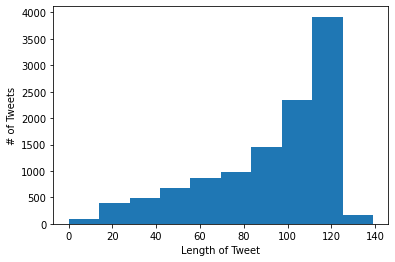

In [61]:
# Histogram with the distribution of the Tweets
plt.hist(df.length)
plt.xlabel('Length of Tweet')
plt.ylabel('# of Tweets')
plt.show()

In [62]:
# Table with the highest and lowest lengths
display(df[df['length']>130])
print('\n')
display(df[df['length']<20])

,keyword,location,text,target,length
id,,,,,
567,attack,,money website my pinned tweet so republicans l...,0,134
568,attack,,i love it when the possessed attack me on here...,0,133
685,avalanche,"Islamabad, Pakistan",breaking news at least people have been kille...,1,132
1003,bleeding,idk im bad at directions,my fatass just tripped on some shit in my room...,1,137
1261,bloody,"Canberra, ACT",sitting in the front room with my bride and th...,0,131
1918,burning,she/her,people that get really hot radiator hands do u...,0,138
2123,catastrophic,,if you sacrifice the president and the senate ...,0,134
2232,chemical emergency,BROKEN Hill,“culture isn’t something that can be drawn fro...,0,136
3261,debris,"Sherfield on Loddon, England",overnight course is very wet with the worst t...,0,131


,keyword,location,text,target,length
id,,,,,
80,aftershock,"Philippines ,From America",a other hard hit,0,17
303,annihilation,"Adelaide, South Australia",annihilation,0,13
336,apocalypse,"Lat Krabang, Bangkok",apocalypse,0,10
337,apocalypse,,…,0,2
348,apocalypse,"Brisbane, Australia",apocalypse chic,0,15
...,...,...,...,...,...
10940,weapons,"Baltimore, MD",still who sent…,0,16
10999,whirlwind,Lucky Landing,ok whirlwind,1,12
11002,whirlwind,,whirlwind,1,9


# Where do the Tweets come from?
We take a first look to the availables places that we have. We are getting the locations that occurs at least 10 times

In [63]:
location = df['location'].value_counts()
location[location>=10][:20]

                           3418
United States                96
Australia                    83
London, England              81
UK                           77
India                        74
London                       69
United Kingdom               59
USA                          52
California, USA              47
Los Angeles, CA              45
England, United Kingdom      39
Lagos, Nigeria               36
Nigeria                      36
Melbourne, Victoria          32
Earth                        31
Ireland                      31
Philippines                  28
Canada                       28
Mumbai, India                27
Name: location, dtype: int64

In [64]:
# We are going to group some places, so we create a mapping dictionary to replace the locations
mapping = {'United States':'USA',
          'New York':'USA',
          "London":'UK',
          "Los Angeles, CA":'USA',
          "Washington, D.C.":'USA',
          "California":'USA',
          "Chicago, IL":'USA',
          "Chicago":'USA',
          "New York, NY":'USA',
          "California, USA":'USA',
          "FLorida":'USA',
          "Nigeria":'Africa',
          "Kenya":'Africa',
          "Everywhere":'Worldwide',
          "San Francisco":'USA',
          "Florida":'USA',
          "United Kingdom":'UK',
          "Los Angeles":'USA',
          "Toronto":'Canada',
          "San Francisco, CA":'USA',
          "NYC":'USA',
          "Seattle":'USA',
          "Earth":'Worldwide',
          "Ireland":'UK',
          "London, England":'UK',
          "New York City":'USA',
          "Texas":'USA',
          "London, UK":'UK',
          "Atlanta, GA":'USA',
          "England, United Kingdom":'UK',
          "Mumbai, India":'India',
          "Melbourne,Victoria":'Australia'}

In [65]:
# We apply a function and change the name of the location to group if it exists on the mapping key
df['location'] = df['location'].apply(lambda i: mapping[i] if i in mapping.keys() else i)

In [66]:
# Now the values changed
ndf = df
ndf.dropna()
location = ndf['location'].value_counts()
location[location>=10]

                         3418
USA                       395
UK                        369
India                     101
Australia                  83
                         ... 
Sioux Falls, SD            10
Dublin, Ireland            10
Queensland, Australia      10
Scotland                   10
Paris, France              10
Name: location, Length: 71, dtype: int64

In [67]:
localizator = Nominatim(user_agent='tweets-analysis') # Creation of the agent 

In [68]:
location = list(location.index) #We keep just the name of the cities
location2 = location[1:1000]

In [69]:
location2 #Now we have a list with the ubication of the tweets

['USA',
 'UK',
 'India',
 'Australia',
 'Worldwide',
 'Africa',
 'Lagos, Nigeria',
 'Canada',
 'Melbourne, Victoria',
 'Philippines',
 'Texas, USA',
 'Nairobi, Kenya',
 'South Africa',
 'New Delhi, India',
 'Sydney',
 'Florida, USA',
 'Sydney, New South Wales',
 'Republic of the Philippines',
 'Malaysia',
 'New York, USA',
 'Moes Tavern, Springfield',
 'Melbourne, Australia',
 'England',
 'Sydney, Australia',
 'Washington, DC',
 'Hong Kong',
 'Pennsylvania, USA',
 'Johannesburg, South Africa',
 'Perth, Western Australia',
 'Portland, OR',
 'Bengaluru, India',
 'Manchester, England',
 'Toronto, Ontario',
 'North Carolina, USA',
 'she/her',
 'South East, England',
 'Abuja, Nigeria',
 'Planet Earth',
 'Ghana',
 'Hyderabad, India',
 'Pretoria, South Africa',
 'Las Vegas, NV',
 'Georgia, USA',
 'San Diego, CA',
 'Scotland, United Kingdom',
 'Global',
 'Accra, Ghana',
 'Singapore',
 'Indonesia',
 'Houston, TX',
 'Seattle, WA',
 'Cape Town, South Africa',
 'Melbourne',
 'Pakistan',
 'Brisbane

In [70]:
# geolocated = list(map(lambda x: [x,localizator.geocode(x,timeout=None)[1] if localizator.geocode(x,timeout=None) else None],location2))
# geolocated = pd.DataFrame(geolocated)
# geolocated.columns = ['locat','latlong']
# try:
#   geolocated['lat'] = geolocated.latlong.apply(lambda x: x[0])
#   geolocated['lon'] = geolocated.latlong.apply(lambda x: x[1])
#   geolocated.drop('latlong',axis=1, inplace=True)
# except:
#   pass

In [71]:
geolocated = pd.read_csv('coords.csv')

FileNotFoundError: ignored

In [ ]:
geolocated.drop(['Unnamed: 0','Unnamed: 0.1'],1,inplace=True)


In [ ]:
geolocated['latlong']=geolocated.latlong.apply(lambda x: x[1:-1].split(','))

In [ ]:
  geolocated['lat'] = geolocated.latlong.apply(lambda x: x[0])
  geolocated['lon'] = geolocated.latlong.apply(lambda x: x[1])
  geolocated.drop('latlong',axis=1, inplace=True)

In [ ]:
geolocated

In [ ]:
geolocated['lat']=pd.to_numeric(geolocated['lat'])
geolocated['lon']=pd.to_numeric(geolocated['lon'])

In [ ]:
world_map = gpd.read_file('World_Countries.shp')
fig,ax = plt.subplots(figsize=(15,15))
world_map.plot(ax=ax)

In [ ]:
crs = {'init':'epsg:4326'}

In [ ]:
geometry = [Point(xy) for xy in zip(geolocated['lon'],geolocated['lat'])]

In [ ]:
geo_df = gpd.GeoDataFrame(geolocated,crs=crs,geometry=geometry)
geo_df.head()

In [ ]:
fig,ax = plt.subplots(figsize=(25,25))
ax.set(facecolor='Powderblue')
ax.set_alpha(0.2)
world_map.plot(ax=ax, alpha=1, color='white')
geo_df.plot(ax=ax,markersize=30,color='darkviolet',marker='o',alpha=0.3)

# Word cloud

In [72]:
import matplotlib as mpl
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [73]:
countries_mask = df['location'].value_counts()
countries_mask

                          3418
USA                        395
UK                         369
India                      101
Australia                   83
                          ... 
Promised Land                1
Corpus Christi, TX           1
ÜT 7.8511327,3.9484197       1
NAIROBI-KENYA                1
Great White North            1
Name: location, Length: 4469, dtype: int64

# Top3 countries

we select top 3 countries with more tweets

## Top words USA

In [75]:
df_usa = df[df['location'] == countries_mask.index[1]]
df_usa

,keyword,location,text,target,length
id,,,,,
2,ablaze,USA,arsonist sets cars ablaze at dealership,1,40
58,accident,USA,in completely available public information th...,0,118
71,aftershock,USA,honored to have an essay in aftershock marking...,0,122
78,aftershock,USA,puerto rico hit by another magnitude aftersho...,1,55
85,aftershock,USA,please pray for puertorico,0,27
...,...,...,...,...,...
11213,wounds,USA,when grandpa said wounds need air whew watchme...,0,50
11259,wreck,USA,why was the sequel to “wreck it ralph” named “...,0,115
11274,wreck,USA,i’m thinking car chase leading to a wreck on t...,0,56


In [76]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1

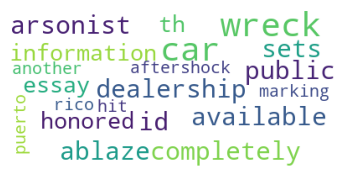

In [77]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='white',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_usa['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [78]:
wordcloud.words_

{'ablaze': 0.5,
 'aftershock': 0.5,
 'another': 0.5,
 'arsonist': 0.5,
 'available': 0.5,
 'car': 1.0,
 'completely': 0.5,
 'dealership': 0.5,
 'essay': 0.5,
 'hit': 0.5,
 'honored': 0.5,
 'id': 0.5,
 'information': 0.5,
 'marking': 0.5,
 'public': 0.5,
 'puerto': 0.5,
 'rico': 0.5,
 'sets': 0.5,
 'th': 0.5,
 'wreck': 1.0}

### Top words in positive emergency

In [79]:
df_usa_positive = df_usa[df_usa['target'] == 1]
df_usa_positive

,keyword,location,text,target,length
id,,,,,
2,ablaze,USA,arsonist sets cars ablaze at dealership,1,40
78,aftershock,USA,puerto rico hit by another magnitude aftersho...,1,55
110,aftershock,USA,the magnitude quake in puertorico this mornin...,1,119
116,airplane accident,USA,like iran shooting an airplane was an accident,1,46
140,airplane accident,USA,so iran can shoot down a commercial airplane a...,1,106
...,...,...,...,...,...
10757,volcano,USA,taal volcano news – live hundreds of thousands...,1,125
11060,wildfire,USA,australia’s koala population has taken such an...,1,107
11081,wildfire,USA,australia wildfire map update high and very hi...,1,125


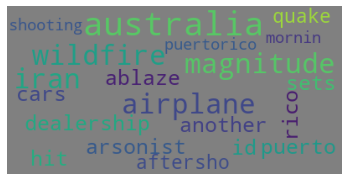

In [80]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_usa_positive['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [81]:
wordcloud.words_

{'ablaze': 0.3333333333333333,
 'aftersho': 0.3333333333333333,
 'airplane': 0.6666666666666666,
 'another': 0.3333333333333333,
 'arsonist': 0.3333333333333333,
 'australia': 1.0,
 'cars': 0.3333333333333333,
 'dealership': 0.3333333333333333,
 'hit': 0.3333333333333333,
 'id': 0.3333333333333333,
 'iran': 0.6666666666666666,
 'magnitude': 0.6666666666666666,
 'mornin': 0.3333333333333333,
 'puerto': 0.3333333333333333,
 'puertorico': 0.3333333333333333,
 'quake': 0.3333333333333333,
 'rico': 0.3333333333333333,
 'sets': 0.3333333333333333,
 'shooting': 0.3333333333333333,
 'wildfire': 0.6666666666666666}

### Top words in negative emergency

In [82]:
df_usa_negative = df_usa[df_usa['target'] == 0]
df_usa_negative

,keyword,location,text,target,length
id,,,,,
58,accident,USA,in completely available public information th...,0,118
71,aftershock,USA,honored to have an essay in aftershock marking...,0,122
85,aftershock,USA,please pray for puertorico,0,27
144,airplane accident,USA,mass antigovernment protests erupt in iran aft...,0,113
151,airplane accident,USA,odd how the iranians accidentally blew up the ...,0,101
...,...,...,...,...,...
11213,wounds,USA,when grandpa said wounds need air whew watchme...,0,50
11259,wreck,USA,why was the sequel to “wreck it ralph” named “...,0,115
11274,wreck,USA,i’m thinking car chase leading to a wreck on t...,0,56


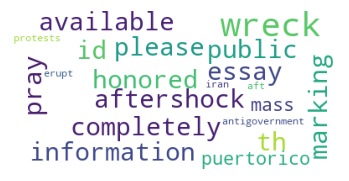

In [83]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='white',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_usa_negative['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [84]:
wordcloud.words_

{'aft': 0.5,
 'aftershock': 0.5,
 'antigovernment': 0.5,
 'available': 0.5,
 'completely': 0.5,
 'erupt': 0.5,
 'essay': 0.5,
 'honored': 0.5,
 'id': 0.5,
 'information': 0.5,
 'iran': 0.5,
 'marking': 0.5,
 'mass': 0.5,
 'please': 0.5,
 'pray': 0.5,
 'protests': 0.5,
 'public': 0.5,
 'puertorico': 0.5,
 'th': 0.5,
 'wreck': 1.0}

## Top words UK

In [85]:
df_uk = df[df['location'] == countries_mask.index[2]]
df_uk

,keyword,location,text,target,length
id,,,,,
6,ablaze,UK,several houses have been set ablaze in ngemsib...,1,115
153,airplane accident,UK,and no excuse for shooting down a commercial a...,0,118
207,ambulance,UK,what racism absolutely delighted…,0,34
213,ambulance,UK,if you have norovirus theres no place like hom...,0,113
219,ambulance,UK,what a lovely message to receive thank you so...,0,52
...,...,...,...,...,...
11105,windstorm,UK,with any luck you will miss the windstorm on e...,0,68
11172,wounded,UK,i personally served with harry in afghan and ...,0,120
11182,wounded,UK,make art make bad art make better art make gre...,0,120


In [86]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1

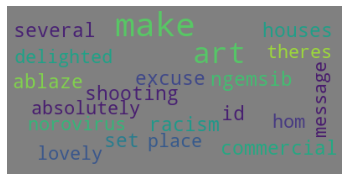

In [87]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_uk['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [88]:
wordcloud.words_

{'ablaze': 0.25,
 'absolutely': 0.25,
 'art': 0.75,
 'commercial': 0.25,
 'delighted': 0.25,
 'excuse': 0.25,
 'hom': 0.25,
 'houses': 0.25,
 'id': 0.25,
 'lovely': 0.25,
 'make': 1.0,
 'message': 0.25,
 'ngemsib': 0.25,
 'norovirus': 0.25,
 'place': 0.25,
 'racism': 0.25,
 'set': 0.25,
 'several': 0.25,
 'shooting': 0.25,
 'theres': 0.25}

### Top words in positive emergency

In [89]:
df_uk_positive = df_uk[df_uk['target'] == 1]
df_uk_positive

,keyword,location,text,target,length
id,,,,,
6,ablaze,UK,several houses have been set ablaze in ngemsib...,1,115
244,annihilated,UK,i will appreciate the bbc igbo when it starts ...,1,117
342,apocalypse,UK,common sense on twitter is this the first sign...,1,80
599,attack,UK,i’m deeply troubled by the news of violent att...,1,118
611,attacked,UK,usasupportsterrorist out of the terrorist th...,1,114
...,...,...,...,...,...
10730,violent storm,UK,the wind is violent outside as a storm moves i...,1,111
10743,violent storm,UK,storm brendan violent storm front currently mo...,1,109
10744,violent storm,UK,storm brendan thousands without power as storm...,1,68


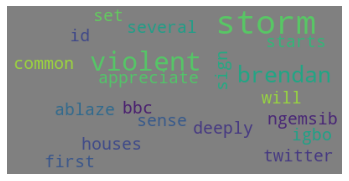

In [90]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_uk_positive['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [91]:
wordcloud.words_

{'ablaze': 0.2,
 'appreciate': 0.2,
 'bbc': 0.2,
 'brendan': 0.4,
 'common': 0.2,
 'deeply': 0.2,
 'first': 0.2,
 'houses': 0.2,
 'id': 0.2,
 'igbo': 0.2,
 'ngemsib': 0.2,
 'sense': 0.2,
 'set': 0.2,
 'several': 0.2,
 'sign': 0.2,
 'starts': 0.2,
 'storm': 1.0,
 'twitter': 0.2,
 'violent': 0.6,
 'will': 0.2}

### Top words in negative emergency

In [92]:
df_uk_negative = df_uk[df_uk['target'] == 0]
df_uk_negative

,keyword,location,text,target,length
id,,,,,
153,airplane accident,UK,and no excuse for shooting down a commercial a...,0,118
207,ambulance,UK,what racism absolutely delighted…,0,34
213,ambulance,UK,if you have norovirus theres no place like hom...,0,113
219,ambulance,UK,what a lovely message to receive thank you so...,0,52
223,ambulance,UK,another race baiting ambulance chaser exposed ...,0,89
...,...,...,...,...,...
11105,windstorm,UK,with any luck you will miss the windstorm on e...,0,68
11172,wounded,UK,i personally served with harry in afghan and ...,0,120
11182,wounded,UK,make art make bad art make better art make gre...,0,120


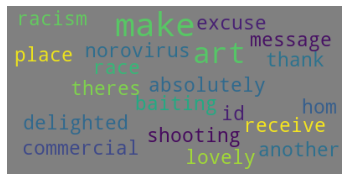

In [93]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_uk_negative['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [94]:
wordcloud.words_

{'absolutely': 0.25,
 'another': 0.25,
 'art': 0.75,
 'baiting': 0.25,
 'commercial': 0.25,
 'delighted': 0.25,
 'excuse': 0.25,
 'hom': 0.25,
 'id': 0.25,
 'lovely': 0.25,
 'make': 1.0,
 'message': 0.25,
 'norovirus': 0.25,
 'place': 0.25,
 'race': 0.25,
 'racism': 0.25,
 'receive': 0.25,
 'shooting': 0.25,
 'thank': 0.25,
 'theres': 0.25}

## Top words India

In [95]:
df_india = df[df['location'] == countries_mask.index[3]]
df_india

,keyword,location,text,target,length
id,,,,,
32,ablaze,India,how can you turn a blind eye to the icident of...,1,86
317,annihilation,India,yeah i was surprised too when i heard it first...,0,91
318,annihilation,India,you dont understand systemic oppression that t...,0,92
391,army,India,the story that caught my eye the davinder sing...,0,116
395,army,India,today pak army soldiers will b thanking to ind...,1,122
...,...,...,...,...,...
10365,trapped,India,would request all consumers not to be trapped ...,0,72
10381,trapped,India,please pray for the safety of soldiers who ha...,1,107
10387,trapped,India,out of five soldiers trapped under the avalanc...,1,107


In [96]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1

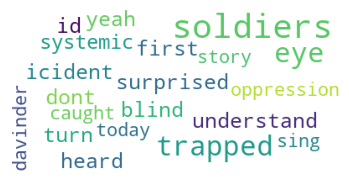

In [97]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='white',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_india['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [98]:
wordcloud.words_

{'blind': 0.3333333333333333,
 'caught': 0.3333333333333333,
 'davinder': 0.3333333333333333,
 'dont': 0.3333333333333333,
 'eye': 0.6666666666666666,
 'first': 0.3333333333333333,
 'heard': 0.3333333333333333,
 'icident': 0.3333333333333333,
 'id': 0.3333333333333333,
 'oppression': 0.3333333333333333,
 'sing': 0.3333333333333333,
 'soldiers': 1.0,
 'story': 0.3333333333333333,
 'surprised': 0.3333333333333333,
 'systemic': 0.3333333333333333,
 'today': 0.3333333333333333,
 'trapped': 0.6666666666666666,
 'turn': 0.3333333333333333,
 'understand': 0.3333333333333333,
 'yeah': 0.3333333333333333}

### Top words in positive emergency

In [99]:
df_india_positive = df_india[df_india['target'] == 1]
df_india_positive

,keyword,location,text,target,length
id,,,,,
32,ablaze,India,how can you turn a blind eye to the icident of...,1,86
395,army,India,today pak army soldiers will b thanking to ind...,1,122
544,attack,India,मुस्लिम महिला छात्रों से गुंडागर्दीpolice atta...,1,70
675,avalanche,India,soldiers civilians killed in avalanches in j...,1,64
677,avalanche,India,including army soldiers one bsf constable ki...,1,86
1111,blizzard,India,i became lost in a himalayan blizzard at mete...,1,74
1758,buildings on fire,India,sad news coming from bhainsa nirmal district t...,1,114
2029,casualties,India,there are reports of massive avalanches in upp...,1,121
2649,crash,India,weaponsyielding thieves crash getaway car leav...,1,90


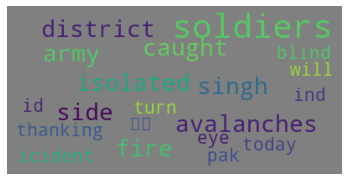

In [100]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_india_positive['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [101]:
wordcloud.words_

{'army': 0.4,
 'avalanches': 0.4,
 'blind': 0.2,
 'caught': 0.4,
 'district': 0.4,
 'eye': 0.2,
 'fire': 0.4,
 'icident': 0.2,
 'id': 0.2,
 'ind': 0.2,
 'isolated': 0.4,
 'pak': 0.2,
 'side': 0.4,
 'singh': 0.4,
 'soldiers': 1.0,
 'thanking': 0.2,
 'today': 0.2,
 'turn': 0.2,
 'will': 0.2,
 'मह': 0.2}

### Top words in negative emergency

In [102]:
df_india_negative = df_india[df_india['target'] == 0]
df_india_negative

,keyword,location,text,target,length
id,,,,,
317,annihilation,India,yeah i was surprised too when i heard it first...,0,91
318,annihilation,India,you dont understand systemic oppression that t...,0,92
391,army,India,the story that caught my eye the davinder sing...,0,116
559,attack,India,trolls launch mala fide campaign against india...,0,111
583,attack,India,‘yehi hai wo sanghi ka room’ bachelors student...,0,101
...,...,...,...,...,...
10265,tornado,India,this chart gives an indication of just how bus...,0,107
10363,trapped,India,would request all consumers not to be trapped ...,0,77
10365,trapped,India,would request all consumers not to be trapped ...,0,72


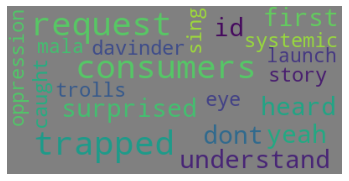

In [103]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                        background_color='gray',
                        stopwords=stopwords,
                        max_words = 20,
                        max_font_size = 40,
                        random_state = 42,
                        ).generate(str(df_india_negative['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [104]:
wordcloud.words_

{'caught': 0.5,
 'consumers': 1.0,
 'davinder': 0.5,
 'dont': 0.5,
 'eye': 0.5,
 'first': 0.5,
 'heard': 0.5,
 'id': 0.5,
 'launch': 0.5,
 'mala': 0.5,
 'oppression': 0.5,
 'request': 1.0,
 'sing': 0.5,
 'story': 0.5,
 'surprised': 0.5,
 'systemic': 0.5,
 'trapped': 1.0,
 'trolls': 0.5,
 'understand': 0.5,
 'yeah': 0.5}